In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from summer2 import CompartmentalModel
from summer2.parameters import Parameter

In [2]:
def build_sis_model(
    model_config: dict,
) -> CompartmentalModel:
    compartments = (
        "susceptible",
        "infectious",
    )
    analysis_times = (
        model_config["start_time"], 
        model_config["end_time"],
    )
    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=["infectious"],
    )
    model.set_initial_population(
        distribution=
        {
            "susceptible": model_config["population"] - model_config["seed"], 
            "infectious": model_config["seed"],
        }
    )
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("contact_rate"),
        source="susceptible", 
        dest="infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=Parameter("recovery"),
        source="infectious", 
        dest="susceptible",
    )
    
    model.request_output_for_flow(
        "incidence",
        "infection",
    )
    
    return model

In [13]:
parameters = {
    "contact_rate": 1.5 / 60.,
    "recovery": 1. / 60.,
}
config = {
    "start_time": 0.,
    "end_time": 50. * 365.,
    "population": 1.,
    "seed": 1e-5,
}

wane_rates = (8, 10, 12)

sis_model = build_sis_model(config)
sis_model.run(parameters=parameters)
sis_outputs = sis_model.get_derived_outputs_df()
sis_outputs.index = sis_outputs.index / 365.
sis_outputs["incidence"] = sis_outputs["incidence"] * 1e5 * 30

## Figure 4.31 a)

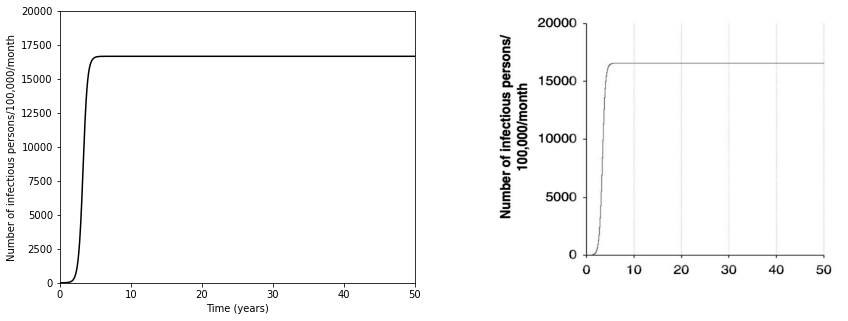

In [14]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    sis_outputs.index,
    sis_outputs["incidence"],
    color="k",
)
left_ax.set_ylim(0., 2e4)
left_ax.set_xlim(0., 50.)
left_ax.set_ylabel("Number of infectious persons/100,000/month")
left_ax.set_xlabel("Time (years)")

image = plt.imread("./figures/fig_4_31a.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

In [5]:
def build_sirs_model(
    model_config: dict,
) -> CompartmentalModel:
    compartments = (
        "susceptible",
        "infectious",
        "recovered",
    )
    analysis_times = (
        model_config["start_time"], 
        model_config["end_time"],
    )
    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=["infectious"],
    )
    model.set_initial_population(
        distribution=
        {
            "susceptible": model_config["population"] - model_config["seed"], 
            "infectious": model_config["seed"],
        }
    )
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("contact_rate"),
        source="susceptible", 
        dest="infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=Parameter("recovery"),
        source="infectious", 
        dest="recovered",
    )
    model.add_transition_flow(
        name="waning",
        fractional_rate=Parameter("waning"),
        source="recovered",
        dest="susceptible",
    )
    
    model.request_output_for_flow(
        "incidence",
        "infection",
    )
    
    return model

In [15]:
parameters = {
    "contact_rate": 1.5 / 60.,
    "recovery": 1. / 60.,
    "waning": 1. / 10. / 365.,
}
config = {
    "start_time": 0.,
    "end_time": 50. * 365.,
    "population": 1.,
    "seed": 1e-5,
}

wane_rates = (8, 10, 12)
sirs_outputs = pd.DataFrame(columns=wane_rates)

for wane_rate in wane_rates:
    parameters.update(
        {
            "waning": (1. / wane_rate + 1. / 30.) / 365.,  # Not sure if we add in this 1/30 bit here ...
        }
    )
    sirs_model = build_sirs_model(config)
    sirs_model.run(parameters=parameters)
    sirs_outputs[wane_rate] = sirs_model.get_derived_outputs_df()["incidence"] * 1e5 * 30.
sirs_outputs.index = outputs.index / 365.

## Figure 4.31 b)

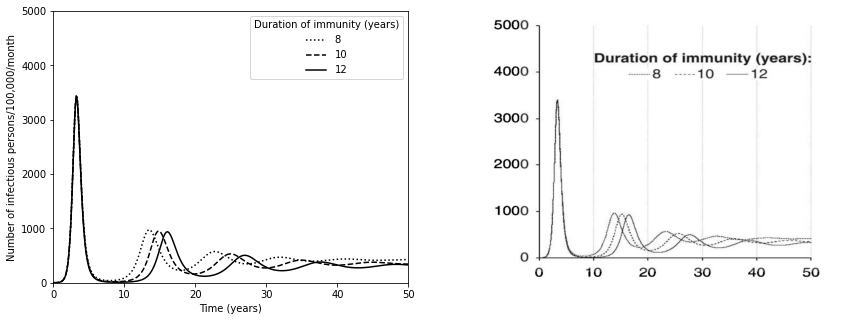

In [16]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

linestyles = (":", "--", "-")

for i_rate, wane_rate in enumerate(wane_rates):
    left_ax.plot(
        sirs_outputs.index,
        sirs_outputs[wane_rate],
        color="k",
        linestyle=linestyles[i_rate],
        label=wane_rate,
    )
left_ax.set_ylim(0., 5e3)
left_ax.set_xlim(0., 50.)
left_ax.set_xlabel("Time (years)")
left_ax.legend(title="Duration of immunity (years)")
left_ax.set_ylabel("Number of infectious persons/100,000/month")

image = plt.imread("./figures/fig_4_31b.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");